In [1]:
import requests as req
import pandas as pd
import os
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
sns.set_theme(style="darkgrid")
import datetime
from statsmodels.tools import add_constant
from sklearn.linear_model import LinearRegression
%matplotlib inline
pd.options.mode.chained_assignment = None

KEY = ''
TIMESCALE = '1y'
DATA_FILE = 'data'#'drive/MyDrive/data'
ETF_DATA_FILE = 'etf_data'

C:\Users\srava\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def get_SP():
  df = pd.read_csv('S&P500-Info.csv')
  return df

def get_sector_etf(sector):
    categories = ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Materials', 'Real Estate', 'Information Technology', 'Utilities']
    return ETF_TICKERS[categories.index(sector)]

# symb = get_SP()[::]['Symbol']
#TICKERS = ['AAPL','XOM']#[symb[i] for i in range(len(symb))]
ETF_TICKERS = ['XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK', 'XLU','VPU','SMH','RTH','RKH','OIH','IYT','IYR']
# print()
# print(ETF_TICKERS)

In [3]:
def get_returns_data_from_csv(df):
    # df = df.dropna(subset='PX_LAST')
    prices = df['PX_LAST']
    ret = np.log(prices/prices.shift(1))
    df['Return'] = ret.fillna(0.0)
    return df

In [4]:
# def get_price_volume_data(dataloc=DATA_FILE):
#     folder = os.listdir(dataloc)
#     N = len(folder)
#     dfs = {}
#     for n, filename in enumerate(folder):
#         if filename == '.DS_Store' or os.path.isdir(filename):
#             continue
#         data = pd.read_csv(os.path.join(dataloc,filename))
#         if dataloc == 'etf_data':
#             isETF = True
#         data = preprocess_data(data, isETF = True)
#         if isinstance(data,str) and data == 'empty':
#             print(filename)
#             continue
        
#         dfs[filename] = data
#     return dfs

In [5]:
# adtvs = get_price_volume_data('data')

In [6]:
def preprocess_data(df,isETF=False):
    if df.empty:
        return 'empty'
    if isETF:
        df = df[2:]
        df['PX_LAST'] = df['PX_LAST'].astype(float)
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df[(df['Dates'] >= '2020-01-01') & (df['Dates'] <= '2023-12-31')]
    if df['PX_LAST'].isna().any():
        return 'empty'
    return df

In [7]:
def avg_daily_volume_filter(adtv):
    if adtv['ADTV'].mean() >= 1e8:
        return True
    return False

In [8]:
def get_returns_data(dataloc=DATA_FILE):
    folder = os.listdir(dataloc)
    N = len(folder)
    # SP500 Data Frame datascrape
    SP = get_SP()
    # map the ticker name to index in the dataframe
    ticker_to_index = {v:k for k,v in SP['Symbol'].to_dict().items()}
    # map returns index to ticker name and sector
    ticker_map = {}
    returns = []
    dates = []
    offset = 0
    isETF = False
    for n, filename in enumerate(folder):
        
        if filename == '.DS_Store' or os.path.isdir(filename):
            offset += 1
            continue
        data = pd.read_csv(os.path.join(dataloc,filename))
        if dataloc == 'etf_data':
            isETF = True
        data = preprocess_data(data, isETF = True)
        #missing prices data
        if isinstance(data,str) and data == 'empty':
            offset+=1
            print(filename)
            continue
        
        if not isETF:
            data['DTV'] = data['PX_VOLUME']*data['PX_LAST']
            data['ADTV'] = data['DTV'].rolling(window=60).mean()
            #average daily volume threshold
            if not avg_daily_volume_filter(data):
                offset+=1
                print(f'{filename} not meeting volume threshold condition')
                continue
        #get returns
        data = get_returns_data_from_csv(data)
        # # only use adjusted close data
        ticker = filename.split('.csv')[0]
        # exclude the first day in returns data
        ret = data.iloc[1:,:]['Return']*100
        ticker_return = ret.to_list()
        # map index -> ticker string, ticker etf
        # map ticker string -> index
        if ticker not in ETF_TICKERS:
            etf_ticker_name = get_sector_etf(SP['GICS Sector'][ticker_to_index[ticker]])
            if etf_ticker_name not in ['XLE', 'XLF', 'XLI', 'XLK', 'XLP','XLV', 'XLY']:
                offset+=1
                continue
            ticker_map[n-offset] = (ticker, etf_ticker_name)
            ticker_map[ticker] = n-offset
        else:
            ticker_map[n-offset] = ticker
            ticker_map[ticker] = n-offset


        dates.append(data.dropna(subset='PX_LAST')['Dates'].to_list())

        returns.append(ticker_return)

    return_mat = np.zeros((len(returns), len(returns[0])))

    for i in range(len(returns)):
        for j in range(len(returns[i])):
            return_mat[i,j] = returns[i][j]

    return return_mat, ticker_map, dates

In [9]:
returns, ticker_map, dates = get_returns_data(DATA_FILE)

ABNB.csv
AIZ.csv not meeting volume threshold condition
ALLE.csv not meeting volume threshold condition
AMCR.csv not meeting volume threshold condition
AOS.csv not meeting volume threshold condition
ATO.csv not meeting volume threshold condition
AVY.csv not meeting volume threshold condition
AXON.csv not meeting volume threshold condition
BEN.csv not meeting volume threshold condition
BIO.csv not meeting volume threshold condition
BR.csv not meeting volume threshold condition
BRO.csv not meeting volume threshold condition
BWA.csv not meeting volume threshold condition
CARR.csv
CBOE.csv not meeting volume threshold condition
CEG.csv
CINF.csv not meeting volume threshold condition
CPT.csv not meeting volume threshold condition
DAY.csv not meeting volume threshold condition
DVA.csv not meeting volume threshold condition
EG.csv not meeting volume threshold condition
EMN.csv not meeting volume threshold condition
EVRG.csv not meeting volume threshold condition
FDS.csv not meeting volume thr

In [10]:
returns.shape

(331, 1042)

In [11]:
etf_returns, etf_map, _ = get_returns_data(ETF_DATA_FILE)

In [12]:
stock_num = 0
print(returns[stock_num].shape)
index = etf_map[ticker_map[stock_num][1]]
sector_returns = etf_returns[index]
print(sector_returns.shape)

(1042,)
(1042,)


In [13]:
list(ticker_map.values())
set([i[1] for i in list(ticker_map.values()) if type(i) is tuple])

{'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLV', 'XLY'}

In [14]:
from scipy.stats import pearsonr

def ETF_factors(returns, etf_returns, period):
    N = len(returns)
    L = np.zeros((N, 1))
    U = np.zeros((N, period))
    cs = []
    for stock in range(N):
        etf = ticker_map[stock][1]
        index = etf_map[etf]
        sector_returns = etf_returns[index]
        # use etf returns as market factors
        if pearsonr(sector_returns[:period], returns[stock][:period])[0] > 0.7:
            cs.append(stock)
        model = LinearRegression().fit(sector_returns.reshape(period, 1), returns[stock].reshape(period, 1))#try fitting intercept
        # factor loadings are the slope of regression
        L[stock] = model.coef_
        # calculate residuals
        U[stock] = returns[stock] - np.matmul(L[stock], sector_returns.reshape(1, period))

    return L, U, cs

In [15]:
start = 100
period = 60
end = start + period
snap_returns = np.transpose(returns.T[start:end])
snap_etf_returns = np.transpose(etf_returns.T[start:end])
L, U, cs = ETF_factors(snap_returns, snap_etf_returns, period)

In [16]:
L.shape
U.shape
returns.shape


(331, 1042)

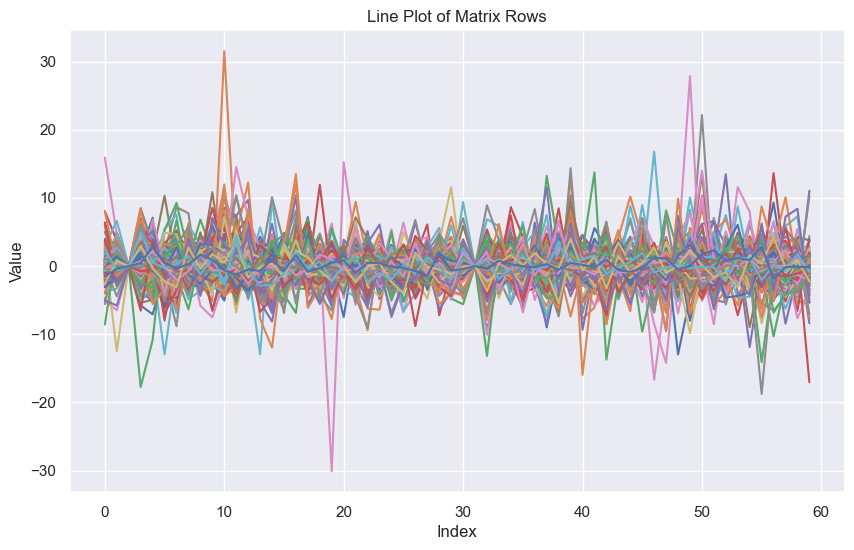

In [17]:
# Plotting each row as a different line
plt.figure(figsize=(10, 6))
for i, row in enumerate(U):
    plt.plot(row, label=f'Row {i}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot of Matrix Rows')
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller
# Perform the ADF test

def remove_non_mean_reverting_residuals(U):
    '''function to remove the non mean reverting residuals'''
    output = []
    for i,residual in enumerate(U):
        adf_result = adfuller(residual)
        # # Print the results
        # print("ADF Statistic:", adf_result[0])
        #print("p-value:", adf_result[1])
        # print("Critical Values:")
        # for key, value in adf_result[4].items():
        #     print(f'   {key}: {value}')

        # Interpretation
        if adf_result[1] < 0.01:
            1
            #print("The residuals are mean-reverting (reject null hypothesis of unit root).")
        else:
            output.append(i)
            #print("The residuals are not mean-reverting (fail to reject null hypothesis of unit root).")
        return output

In [19]:
def OU_estimation(L, U):
    stock_score = []
    stock_kappa = []

    for i in range(len(U)):
        X = np.cumsum(U[i])
        t = len(X) - 1
        Xt = X[0:-1].reshape(t,1)
        Xt1 = X[1:].reshape(t,1)
        ls = LinearRegression(fit_intercept=True).fit(Xt, Xt1)
        beta = ls.coef_[0][0]
        if beta > 1 :
            beta = .9672 #why this?
        alpha = ls.intercept_[0]
        # epsilon -> random process of t+1 residual
        epsilon = Xt1 - alpha - beta * Xt
        k = -np.log10(beta) * 252
        m = alpha / (1 - beta)
        sigma = np.sqrt((np.var(epsilon))/(1-np.power(beta, 2)))
        score = (X[t]-m) / sigma
        # print(f'score {score}, {i}')
        # adjust score for drift
        modscore = (score - (alpha/(k*sigma)))
        stock_kappa.append(k)
        stock_score.append(modscore)

    return stock_kappa, stock_score

In [23]:
def backtest_main(sbc, sbo, ssc, sso):
    # Backtesting program
    first = 60
    last = 250
    cash = 300000
    estimation_window = 60
    total_return = []
    portfolio_breakdown = []
    portfolio = {}
    positions = {n:0 for n in range(len(returns))}
    ticker_stats = {ticker_map[n][0]:0 for n in range(len(returns))}
    etf_stats = {etf_map[n]:0 for n in range(len(etf_returns))}
    kval = []
    signal_evo = []
    for day in range(first, last):
        end = day
        start = day - estimation_window
        period = end - start
        # get returns matrix of just start:end
        snap_returns = np.transpose(returns.T[start:end])
        snap_etf_returns = np.transpose(etf_returns.T[start:end])
        # calculate market factors and residuals
        L, U, correlated_stocks = ETF_factors(snap_returns, snap_etf_returns, period)
        non_mean_reverting_stocks = remove_non_mean_reverting_residuals(U)

    #     # Create a mask that is True for rows to keep
    #     mask = np.ones(matrix_data.shape[0], dtype=bool)
    #     mask[rows_to_remove] = False

    #     # Filtered matrix
    #     filtered_matrix = matrix_data[mask]

        kappa, signal = OU_estimation(L, U)
        # filter out stocks based on mean reversion factor
        # estimated mean reversion must occur within ~8 days
        filtered = [i for i,x in enumerate(kappa) if (x > (252/(estimation_window * 0.5)))] #why not x > 8 days


        # generate returns from portfolio at the start of the trading day
        returns_mat = returns.T[day]
        etf_returns_mat = etf_returns.T[day]
        day_returns = 0

        for ticker in portfolio.keys():
            if ticker in ETF_TICKERS:
                index = etf_map[ticker]
                etf_return = portfolio[ticker] * (etf_returns_mat[index]/100)
                # print(f'{ticker} return: {etf_return}, {etf_returns_mat[index]/100}')
                day_returns += etf_return
                etf_stats[ticker] += etf_return
            else:
                index = ticker_map[ticker]
                stock_return = portfolio[ticker] * (returns_mat[index]/100)
                # print(f'{ticker} return: {stock_return}, {returns_mat[index]/100}')
                day_returns += stock_return
                ticker_stats[ticker] += stock_return

        #print(f'Day {day} returns: {day_returns}')
        #print('\n')

        # calculate long/short percentages
        total_long = sum([val for val in portfolio.values() if val > 0])
        total_short = sum([val for val in portfolio.values() if val < 0])
        portfolio_breakdown.append((total_long/cash, total_short/cash))

        # track returns, kappa values, and signals for graphing
        total_return.append(float(day_returns))
        kval.append(kappa)
        signal_evo.append(signal)

        # assign new positions using closing prices
        for n, sig in enumerate(signal):
            take_pos = n in filtered and n not in non_mean_reverting_stocks and n in correlated_stocks
            # if we already have a position, check for exit condition
            if take_pos: #only take position if model is valid K > 8.4
                if positions[n] != 0:
                    if (positions[n] == 1 and sig > sbc) or (positions[n] == -1 and sig < ssc): #-.0.5, 1.25
                        positions[n] = 0
                    if not take_pos:
                        positions[n] = 0

                # if we don't have a position, check for entry condition
                else:
                    if sig < sbo and take_pos: #-1.25
                        positions[n] = 1

                    elif sig > sso and take_pos: #2
                        positions[n] = -1


                    else:
                        positions[n] = 0


        # equal weight every position in the portfolio
        # could modify to an optimization problem
        total_pos = len([pos for pos in positions.values() if pos != 0])

        # create new portfolio
        # pair trade stock and associated etf
        portfolio = {}
        for pos in positions.items():
            index = pos[0]
            stock, etf = ticker_map[index]
            # long stock, short etf
            if pos[1] == 1:
                long = (1 / total_pos) * cash
                short = L[index][0] * long * -1
                portfolio[stock] = long
                if etf in portfolio.keys():
                    portfolio[etf] += short
                else:
                    portfolio[etf] = short

            # short stock, long etf
            elif pos[1] == -1:
                short = (1 / total_pos) * cash * -1
                long = short * L[index][0] * -1
                portfolio[stock] = short
                if etf in portfolio.keys():
                    portfolio[etf] += long
                else:
                    portfolio[etf] = long






    print('\n')
    plt.figure(1)
    # plot the cumulative pnl for the backtest
    plt.xlabel('Business Days In Backtest')
    plt.ylabel('Cumulative PnL ($)')
    sns.lineplot(data=np.cumsum(total_return, dtype=object))
    plt.savefig('cumulativepnl')


    print('\n')
    print(f'Total Return: {np.sum(total_return)}')
    percent = (np.sum(total_return)/cash)*100
    print('Percentage Return: {:.2f}%'.format(percent))
    sharpe = (np.mean(total_return)/np.std(total_return))* (252 ** .5)
    print(f'Sharpe Ratio: {sharpe}')
    return [percent, sharpe]





Total Return: 23408.735175781047
Percentage Return: 7.80%
Sharpe Ratio: 1.1003509505157425


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 26925.097626313316
Percentage Return: 8.98%
Sharpe Ratio: 1.2904998080746448


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 39441.42096339095
Percentage Return: 13.15%
Sharpe Ratio: 1.8363509660506114


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 31365.012021716786
Percentage Return: 10.46%
Sharpe Ratio: 1.528862688877771


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 27357.08316650596
Percentage Return: 9.12%
Sharpe Ratio: 1.4343472880029544


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 7097.07593731037
Percentage Return: 2.37%
Sharpe Ratio: 0.4540773264431008


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 6900.521272848089
Percentage Return: 2.30%
Sharpe Ratio: 0.4493841914091877


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 9513.599217916126
Percentage Return: 3.17%
Sharpe Ratio: 0.5298814539538512


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):






Total Return: 8355.290436968848
Percentage Return: 2.79%
Sharpe Ratio: 0.4794231592116388


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


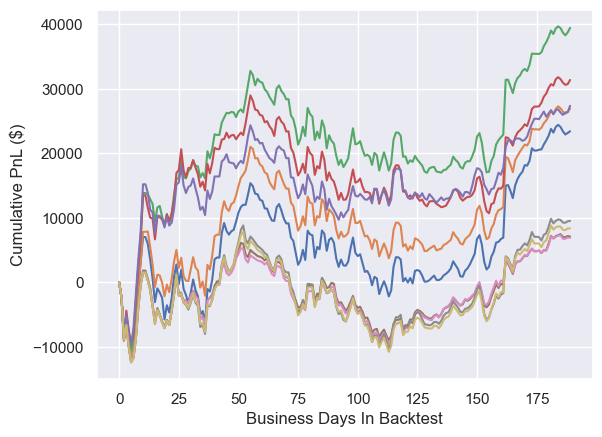

In [24]:
sbc = -0.5
sbo = -1.25
sso = 2
ssc = 1.25
ans = backtest_main(sbc, sbo, ssc, sso)
for i in [0.25,0.5]:
    sbc = sbc - i
    out = backtest_main(sbc, sbo, ssc, sso)
    ans.append(out)
    
for i in [0.25,0.5]:
    sbc = sbo - i
    out = backtest_main(sbc, sbo, ssc, sso)
    ans.append(out)
    
for i in [0.25,0.5]:
    sbc = sso + i
    out = backtest_main(sbc, sbo, ssc, sso)
    ans.append(out)
    
for i in [0.25,0.5]:
    sbc = ssc + i
    out = backtest_main(sbc, sbo, ssc, sso)
    ans.append(out)





Total Return: 37532.3707625829
Percentage Return: 12.51%
Sharpe Ratio: 1.7932755145475954


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


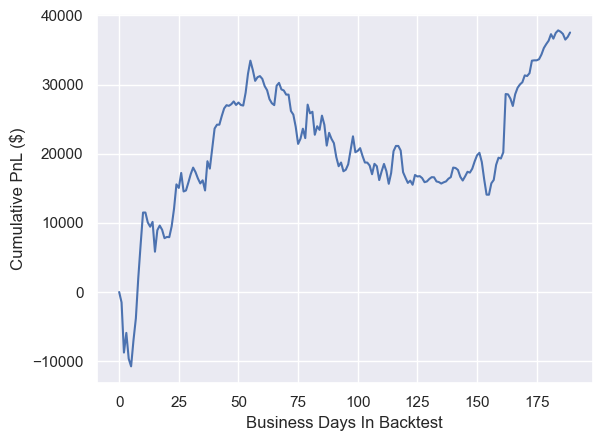

In [25]:
sbc = -1
sbo = -1.75
sso = 2
ssc = 1.25
out1 = backtest_main(sbc, sbo, ssc, sso)





Total Return: 40322.01546844425
Percentage Return: 13.44%
Sharpe Ratio: 1.9754785548941465


C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\srava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


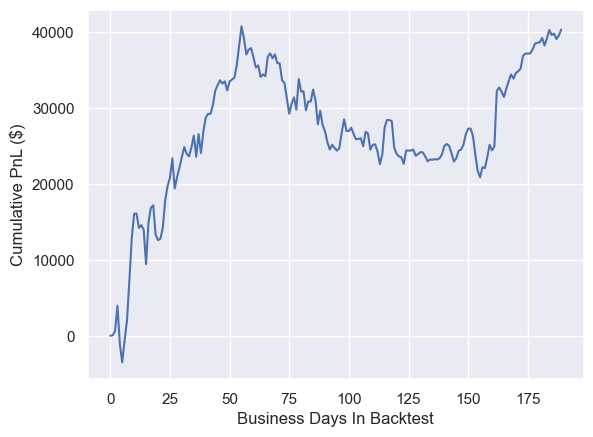

In [26]:
out2 = backtest_main(sbc, sbo-0.25, ssc, sso)